<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Детекция объектов</b></h3>

В этом домашнем задании мы продолжим работу над детектором из семинара, поэтому при необходимости можете заимствовать оттуда любой код.

Домашнее задание можно разделить на следующие части:

* Переделываем модель [5]
  * backbone[1],
  * Neck [3],
  * Head [1]
* Label assignment [2]:
  * TAL [2]
* Лоссы [1]:
  * CIoU loss [1]
* Кто больше? [5]
  * 0.15 mAP [1]
  * 0.2 mAP [2]
  * 0.3 mAP  [3]
  * 0.5 mAP [5]

**Максимальный балл:** 10 баллов. (+3 балла бонус).

In [ ]:
import torch
import numpy as np
import pandas as pd
import albumentations as A

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
from albumentations.pytorch.transforms import ToTensorV2

### Загрузка данных

Мы продолжаем работу с датасетом из семинара - Halo infinite ([сслыка](https://universe.roboflow.com/graham-doerksen/halo-infinite-angel-aim)). Загрузка данных и создание датасета полностью скопированы из семинара.

Сначала загружаем данные

In [ ]:
splits = {'train': 'data/train-00000-of-00001-0d6632d599c29801.parquet',
          'validation': 'data/validation-00000-of-00001-c6b77a557eeedd52.parquet',
          'test': 'data/test-00000-of-00001-866d29d8989ea915.parquet'}
df_train = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["test"])

Создаем датасет для предобработки данных

In [ ]:
class HaloDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        df_objects = pd.json_normalize(dataframe['objects'])[["bbox", "category"]]
        df_images = pd.json_normalize(dataframe['image'])[["bytes"]]
        self.data = dataframe[["image_id"]].join(df_objects).join(df_images)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """Загружаем данные и разметку для объекта с индексом `idx`.

        labels: List[int] Набор классов для каждого ббокса,
        boxes: List[List[int]] Набор ббоксов в формате (x_min, y_min, w, h).
        """
        row = self.data.iloc[idx]
        image = Image.open(io.BytesIO(row["bytes"]))
        image = np.array(image)

        target = {}
        target["image_id"] = row["image_id"]

        labels = [row["category"]] if isinstance(row["category"], int) else row['category']
        # Вычитаем единицу чтобы классы начинались с нуля
        labels = [label - 1 for label in labels]
        boxes = row['bbox'].tolist()

        if self.transform is not None:
            transformed = self.transform(image=image, bboxes=boxes, labels=labels)
            image, boxes, labels = transformed["image"], transformed["bboxes"], transformed["labels"]
        else:
            image = transforms.ToTensor()(image)

        target['boxes'] = torch.tensor(np.array(boxes), dtype=torch.float32)
        target['labels'] = torch.tensor(labels, dtype=torch.int64)
        return image, target

def collate_fn(batch):
    batch = tuple(zip(*batch))
    images = torch.stack(batch[0])
    return images, batch[1]

Тут можно написать любые аугментации

In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        # Добавляй сюда свои аугментации при необходимости!
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    # Раскомментируй, если аугментации изменяют ббоксы.
    # Не забудь указать верный формат для ббоксов.
    # bbox_params=A.BboxParams(format='coco', label_fields=['labels'])
)

test_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

Не забываем инициализировать наш датасет

In [ ]:
train_dataset = HaloDataset(df_train, transform=train_transform)
test_dataset = HaloDataset(df_test, transform=test_transform)

## Переделываем модель [5 баллов]

В семинаре мы реализовали самый базовый детектор, а сейчас настало время его улучшать. 

### Backbone [1 балл]

В лекции мы заморозили все слои у модели. Вам нужно написать бекбоун с возможностью разморозки __k__ последних слоев или блоков (на ваш выбор).

In [ ]:
class Backbone(nn.Module):
    def __init__(self, ..., unfreeze_last=k):
        # YOUR CODE HERE!

    def forward(self, x):
        # YOUR CODE HERE!

### NECK [3 балла]

Вам предлагается на выбор написать одну из двух шей:

#### Feature Pyramid Network [2 балла]

Знакомая из лекции архитектура шеи:

<center><img src="https://user-images.githubusercontent.com/57972646/69858594-b14a6c00-12d5-11ea-8c3e-3c17063110d3.png"/></center>


* [Feature Pyramid Networks for Object Detection](https://arxiv.org/abs/1612.03144)

Она состоит из top-down пути, в котором происходит 2 вещи:
1. Увеличивается пространственная размерность фичей,
2. С помощью скипконнекшеннов, добавляются фичи из backbone модели.

Для увеличения пространственной размерности используется __nearest neighbor upsampling__, а фичи из шеи и бекбоуна суммируются.

#### Path Aggregation Network [3 балла]

Другая архитектура немного сложнее. Она содержит не только top-down путь, но ещё bottom-up путь:

<center><img src="https://miro.medium.com/v2/resize:fit:1038/1*wIK9CIal9v2UwHmBfHy-Wg.png"/></center>

* [Path Aggregation Network for Instance Segmentation](https://arxiv.org/abs/1803.01534)

Подробное описание архитектуры можно найти в секции 3 (Framework).


__TIPS__:
* Можете использовать базовые классы из лекции,
* Воспользуйтесь AnchorGenerator-ом, чтобы создавать якоря сразу для нескольких выходов,
* Не забудьте использовать nn.ModuleList, если захотите сделать динамическое количество голов у модели.

In [ ]:
import torch.nn as nn

class Neck(nn.Module):
    def __init__(self, ):
        # YOUR CODE HERE

    def forward(self, features):
        # YOUR CODE HERE

### Head [1 балл]

В качестве шеи можно выбрать __один из двух__ вариантов:

#### 1. Decoupled Head

Реализовать Decoupled Head из [YOLOX](https://arxiv.org/abs/2107.08430).
<center>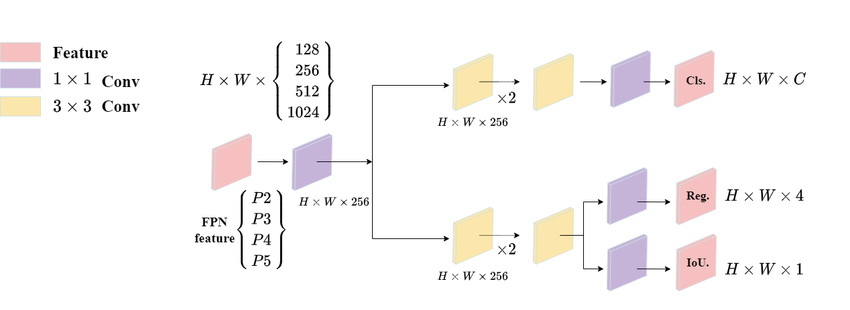</center>

**TIP**: Возьмите за основу голову из семинара, тк она сильно похожа на Decoupled Head.

Изменять количество параметров у шей на разных уровнях не обязательно.

#### 2. Confidence score free head

Нужно взять за основу голову из семинара и полностью убрать предсказание confidence score. Чтобы модель предсказывала только 2 группы: ббоксы и классы.

Есть следующие способы удаления confidence score:
* Добавление нового класса ФОН. Обычно его обозначают нулевым классом.
* Присваивание ббоксам БЕЗ объекта вектор из нулей в качестве таргета.

Выберете тот, который вам больше нравится и будте внимательны при расчете лосса! 

**Важно!** Удаление confidence score повлияет на следующие методы из семинара:
* target_assign
* ComputeLoss
* _filter_predictions

In [ ]:
class Head(nn.Module):
    def __init__(self, ...):
        # YOUR CODE HERE

    def forward(self, x):
        # YOUR CODE HERE

Теперь можно снова реализовать класс детектора с учетом всех частей выше!

In [ ]:
class Detector(nn.Module):
    # YOUR CODE HERE

## Label assignment [2]
В этой секции предлагается заменить функцию `assign_target` на более современный алгоритм который называется Task alignment learning.

Он описан в статье [TOOD](https://arxiv.org/abs/2108.07755) в секции 3.2. Для удобства вот его основные шаги:

1. Посчитать значение метрики для каждого предсказанного ббокса:
    
    $$
    t = s^\alpha * u^\beta
    $$
    
    где 
    
    $s$ — classification score, или вероятность принадлежности предсказанного ббокса к классу реального ббокса (**GT**);
    
    $u$ — IoU между предсказанным и реальным ббоксами;
    
    $\alpha,\ \beta$ — нормализационные константы, обычно $\alpha = 6.0, \ \beta = 1.0$.
    
2. Отфильтровать предсказания на основе **GT**.

    Для якорных детекторов, обычно, выбираются только те предсказания, центры якорей которых находятся внутри GT.
4. Для каждого **GT** выбрать несколько (обычно 5 или 13) самых подходящих предсказаний.
5. Если предсказание рассматривается в качестве подходящего для нескольких **GT** — выбрать **GT** с наибольшим пересечением по IoU.


**BAЖНО**: если будете использовать Runner из лекции, не забудьте поменять параметры  в `self.assign_target_method` в методе `_run_train_epoch`.

In [ ]:
def TAL_assigner(...):
    # YOUR CODE HERE!

### DIoU [1]

Вместо SmoothL1, который используется в семинаре, реализуем лосс, основанный на пересечении ббоксов. В качестве тренировки давайте напишем Distance Intersection over Union (DIoU).

<center><img src=https://wikidocs.net/images/page/163613/Free_Fig_5.png></center>

Для его реализации разобъем задачу на части:

**1. Реализуем IoU:**

Пусть даны координаты для предсказанного ($B^p$) и истинного ($B^g$) ббоксов в формате XYXY или VOC PASCAL (левый верхний и правый нижний углы):

$B^p=(x^p_1, y^p_1, x^p_2, y^p_2)$, $B^g=(x^g_1, y^g_1, x^g_2, y^g_2)$, тогда алгоритм расчета будет следующий:

    1. Найдем площади обоих ббоксов:
$$ A^p = (x^p_2 - x^p_1) * (y^p_2 - y^p_1) $$
$$ A^g = (x^g_2 - x^g_1) * (y^g_2 - y^g_1) $$

    2. Посчитаем пересечение между ббоксами:

Тут мы предлагаем вам подумать как в общем виде можно расчитать размеры ббокса, который будет являться пересечением $B^p$ и $B^g$, а затем посчитать его площадь:

$$x^I_1 = \qquad \qquad y^I_1 = $$
$$x^I_2 = \qquad \qquad y^I_2 = $$

В общем виде, площать будет записываться следующим образом:

Если $x^I_2 > x^I_1$ & $y^I_2 > y^I_1$, тогда:

$$I = (x^I_2 - x^I_1) * (y^I_2 - y^I_1)$$

Иначе, $I = 0$.

    3. Считаем объединение ббоксов.

Мы можем посчитать эту площадь как сумму площадей двух ббоксов минус площадь пересечения (тк мы считаем её два раз в сумме площадей):

$$U = A^p + A^g - I$$

    4. Вычисляем IoU.

$$IoU = \frac{I}{U}$$

**2. Рассчитаем площадь выпуклой оболочки:**

Для расчета площади, сначала выпишите координаты верхнего левого и правого нижнего углов. Подумайте, чему будут равны эти координаты в общем случае?

$$x^С_1 = \qquad \qquad y^С_1 = $$
$$x^С_2 = \qquad \qquad y^С_2 = $$

Подсказка: Нарисуйте несколько вариантов пересечений предсказания и GT на бумажке, и выпишите координаты для выпуклой оболочки.

$$C = (x^C_2 - x^C_1) * (y^C_2 - y^C_1)$$

**3. Рассчитаем расстояние между цетрами ббоксов:**

Сначала находим координаты центров каждого из ббоксов (если ббоксы в формате YOLO, то и считать ничего не нужно), затем считаем Евклидово расстояние между центрами.

$d = $

Собираем все части вместе и считаем лосс по формуле:

$$ DIoU = 1 - IoU + \frac{d^2}{C^2}$$

Помните, что пар ббоксов может быть много! Возвращайте усредненное значение лосса.

In [ ]:
from torchvision.ops import distance_box_iou_loss

In [ ]:
def gen_bbox(num_boxes=10):
    min_corner = torch.randint(0, 100, (num_boxes, 2))
    max_corner = torch.randint(50, 150, (num_boxes, 2))

    for i in range(2):
        wrong_order = min_corner[:, i] > max_corner[:, i]
        if wrong_order.any():
            min_corner[wrong_order, i], max_corner[wrong_order, i] = max_corner[wrong_order, i], min_corner[wrong_order, i]
    return torch.cat((min_corner, max_corner), dim=1)        

In [ ]:
pred_boxes = gen_bbox(num_boxes=100)
true_boxes = gen_bbox(num_boxes=100)

In [ ]:
print(f" DIoU: {distance_box_iou_loss(pred_boxes, true_boxes, reduction="mean").item()}")

In [ ]:
def ciou_loss(pred_boxes, gt_boxes):
  # TODO
  return

In [ ]:
import numpy as np
pred_boxes = gen_bbox(num_boxes=1000)
true_boxes = gen_bbox(num_boxes=1000)

# проверим что написанный лосс выдает те же результаты что и лосс из торча.
assert np.isclose(ciou_loss(pred_boxes, true_boxes), distance_box_iou_loss(pred_boxes, true_boxes, reduction="mean").item())

## Кто больше? [5 баллов]

Наконец то мы дошли до самый интересной части. Тут мы раздаем очки за mAP'ы!

Все что вы написали выше вам поможет улучшить качество итогового детектора, настало время узнать насколько сильно :)

За достижения порога по mAP на тестовом наборе вы получаете баллы:
* 0.15 mAP [1]
* 0.2 mAP [2]
* 0.3 mAP  [3]
* 0.6 mAP [5]


**TIPS**:
1. На семинаре мы специально не унифицировали формат ббоксов между методами, чтобы обратить ваше внимание что за этим нужно следить. Чтобы было проще, сразу унифицируете формат по всему ноутбуку. Советуем использовать формат xyxy, тк IoU и NMS из torch используют именно этот формат. (Не забудьте поменять формат у таргета в `HaloDataset`).
2. Попробуйте перейти к IoU-based лоссу при обучении. То есть обучать не смещения, а сразу предсказывать ббокс.
3. Поэксперементируйте с подходами target assignment'а в процессе обучения. Например, можно на первых итерациях использовать обычный метод, а затем подключить TAL.
4. Добавьте аугментаций!
5. Попробуйте добавлять различные блоки из YOLO архитектур в шею вместо единичных конволюционных слоев. (Например, замените конволюции 3х3 на CSP блоки).
6. Не бойтесь эксперементировать и удачи!

Также, напишите развернутые ответы на следующие вопросы:

**Questions:**
1. Какой метод label assignment'a помогает лучше обучаться модели? Почему?
2. Какое из сделаных вами улучшений внесло наибольший вклад в качество модели? Как вы думаете, почему это произошло?
3. Какое из сделанных вами улучшений вообще не изменило метрику? Как вы думаете, почему это произошло?

In [ ]:

# Место для обучения, валидации и экспериментов!


Ниже определена вспомогательная функция для валидации качества. Можете использовать `Runner.validate`. Важное уточнение, ей нужен метод для фильтрации предсказаний. Можете тоже скопировать его из семинара, если он у вас не менялся.

In [ ]:
from torchmetrics.detection import MeanAveragePrecision

@torch.no_grad()
def validate(dataloader, filter_predictions_func, box_format="xyxy", device="cpu", score_threshold=0.1, nms_threshold=0.5, **kwargs):
    """ Метод для валидации модели.
    Возвращает mAP (0.5 ... 0.95).
    """
    self.model.eval()
    # Считаем метрику mAP с помощью функции из torchmetrics
    metric = MeanAveragePrecision(box_format=box_format, iou_type="bbox")
    for images, targets in tqdm(dataloader, desc="Running validation", leave=False):
        images = images.to(device)
        outputs = self.model(images)
        predicts = filter_predictions_func(outputs, score_threshold, nms_threshold, **kwargs)
        metric.update(predicts, targets)
    return metric.compute()["map"].item()
